In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

デバイス毎に音楽の再生音量の最大値は異なる．騒音の大きさから，再生音量を実数値( $0 \leq x \leq 1.0$ )で求める関数があると便利．  
デバッグ用 SC-04J 上でAudioRecoderで計測した音量の値（騒音）と，その時に設定した音楽の再生音量を記録． 
適当な関数にフィットさせて実数を返す関数を作る．

In [2]:
# 実際の測定結果を元に，擬似データを作成する関数
def labelDispenser(x: int) -> int:
    if x < 0:
        raise ValueError("負値")
    if x < 750:
        return 0
    elif x < 3750:
        return 1
    elif x < 9750:
        return 2
    elif x < 20000:
        return 3
    elif x < 30000:
        return 4
    elif x <= 32767:
        return 5
    else:
        raise ValueError("大きすぎ")

# 再生音量は SC-04J  では15段階中での整数値であり，これを 0　から1.0 までの実数値に射影する
x = np.arange(0,32767,10)
y = np.frompyfunc(labelDispenser,1,1)(x)
df = pd.DataFrame({"騒音":x, "再生音量":y})
df["再生音量（実数値）"] = df["再生音量"] / 15

騒音とそのときの再生音量の対応イメージ


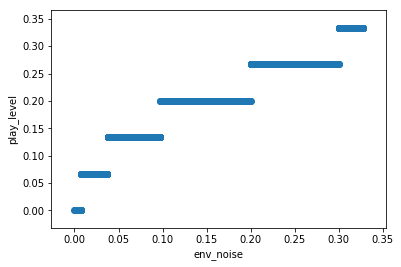

In [3]:
# 騒音値が10^3オーダ，再生音量が10^-1オーダなので，オーダを再生音量側に揃える
# プロット
x = df.loc[:,"騒音"] / 100000
y = df.loc[:,"再生音量（実数値）"]
plt.scatter(x, y)
plt.xlabel("env_noise")
plt.ylabel("play_level")
print("騒音とそのときの再生音量の対応イメージ")

この段々になっているグラフを滑らかにしたような関数が欲しい

In [4]:
# 再生音量の変化位置（境界）に注目
x = np.array([750, 3750, 9750, 20000, 30000]) / 100000
y = np.array([0.5, 1.5, 2.5, 3.5, 4.5]) / 15

# a + bx にフィット
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
print(lr.score(np.array(x).reshape(-1, 1),y), lr.intercept_, lr.coef_)

# a + bx + cx^2 にフィット
lr2 = LinearRegression().fit(np.dstack((np.power(np.array(x),2),np.array(x)))[0], y)
print(lr2.score(np.dstack((np.power(np.array(x),2),np.array(x)))[0],y), lr2.intercept_, lr2.coef_)

# a + b log(x) にフィット
log_r = LinearRegression().fit(np.array(np.log(x[1:])).reshape(-1, 1), y[1:])
print(log_r.score(np.array(np.log(x[1:])).reshape(-1, 1),y[1:]), log_r.intercept_, log_r.coef_)

# a + b sqrt(x) にフィット
lr3 = LinearRegression().fit(np.array(np.sqrt(x)).reshape(-1, 1), y)
print(lr3.score(np.array(np.sqrt(x)).reshape(-1, 1),y), lr3.intercept_, lr3.coef_)

0.9566515430381373 0.05703034713007743 [0.85320093]
0.9858850873387448 0.0357204977287037 [-1.91782117  1.43981898]
0.9695780780725732 0.39569447022473625 [0.09291432]
0.9981469854250034 -0.013011305980174026 [0.56593706]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


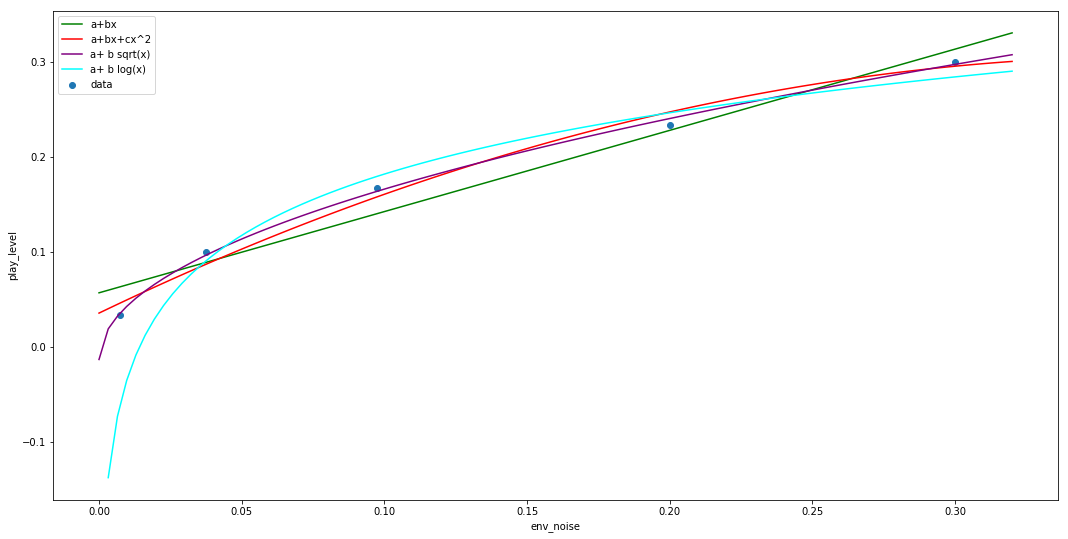

In [5]:
# グラフ描写
RNG = np.linspace(0, 0.32, 100)
plt.figure(figsize=(18,9))
plt.scatter(x, y, label="data")
plt.xlabel("env_noise")
plt.ylabel("play_level")
plt.plot(RNG, lr.intercept_ + lr.coef_ * RNG, label="a+bx", color="green")
plt.plot(RNG, lr2.intercept_ + lr2.coef_[1] * RNG + lr2.coef_[0] * RNG * RNG, label="a+bx+cx^2", color="red")
plt.plot(RNG, lr3.intercept_ + lr3.coef_ * np.sqrt(RNG), label="a+ b sqrt(x)", color="purple")
plt.plot(RNG, log_r.intercept_ + log_r.coef_ * np.log(RNG), label="a+ b log(x)", color="cyan")
plt.legend(loc='upper left')

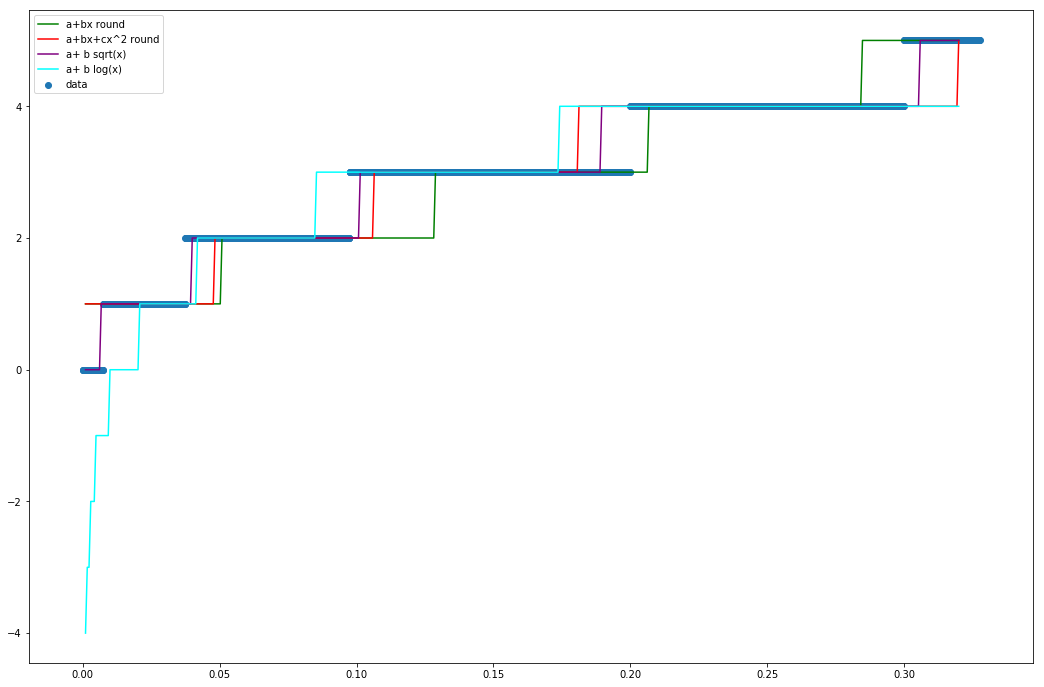

In [9]:
# 騒音から再生音量を求める関数を用いて，実際にデバイスの再生音量を決定してみる
# 関数の値を四捨五入して整数化

RNG = np.linspace(0.001, 0.32, 500)
DIV_NUM = 15  # デバイス毎に異なる，再生音量の最大値

plt.figure(figsize=(18,12))
plt.scatter(df["騒音"]/100000, df["再生音量"], label="data")
plt.plot(RNG, np.round(DIV_NUM * (lr.intercept_ + lr.coef_[0] * RNG)), label="a+bx round", color="green")
plt.plot(RNG, np.round(DIV_NUM * (lr2.intercept_ + lr2.coef_[1] * RNG + lr2.coef_[0] * RNG * RNG)), label="a+bx+cx^2 round", color="red")
plt.plot(RNG, np.round(DIV_NUM * (lr3.intercept_ + lr3.coef_ * np.sqrt(RNG))), label="a+ b sqrt(x)", color="purple")
plt.plot(RNG, np.round(DIV_NUM * (log_r.intercept_ + log_r.coef_ * np.log(RNG))), label="a+ b log(x)", color="cyan")
plt.legend(loc='upper left')

イメージとのギャップが最も小さい $ y = a + b \sqrt{x} $ を実装する